In [2]:
install = False

if install:
  !pip install lingam
  !pip install econml
  !pip install dowhy

# Data is taken from Kaggle insurance dataset: https://www.kaggle.com/code/prathamkyada/insurance-premium-prediction/input?select=insurance.csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

#LiNGAM algorithm for causal discovery
from lingam import DirectLiNGAM
from lingam.utils import make_dot

# EconML and sklearn pacakges for heterogeneous treatment effect estimation
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV

#DoWhy
import dowhy
from dowhy.utils import plot

# Show all columns regardless of how many there are
pd.set_option('display.max_columns', None)
# Increase the width of the display area
pd.set_option('display.width', 2000)
# Optional: suppress scientific notation for clearer causal weights
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def display_df(df):
  styled_df = df.style.format("{:.3f}").set_table_styles([
    {'selector': 'th', 'props': [('white-space', 'nowrap')]},
    {'selector': 'td', 'props': [('white-space', 'nowrap')]}
  ])

  display(styled_df)


data_df = pd.read_csv('insurance.csv').rename(columns={'sex':'gender'})
data_df.head(1)
print(data_df.describe())
print(data_df.info())
numeric_cols = data_df.select_dtypes(exclude='object').columns.tolist()
print(numeric_cols)

# Data pre-processing
df = data_df.copy()
target_var = "expenses"
# Ensure binary variables are numeric
df['gender'] = df['gender'].map({'male':0, 'female':1})
df['smoker'] = df['smoker'].map({'no':0, 'yes':1})
df = pd.get_dummies(df, columns=['region'], drop_first=True)
df = df.astype(float)
col_names = df.columns.tolist()


            age       bmi  children   expenses
count 1338.0000 1338.0000 1338.0000  1338.0000
mean    39.2070   30.6655    1.0949 13270.4224
std     14.0500    6.0984    1.2055 12110.0112
min     18.0000   16.0000    0.0000  1121.8700
25%     27.0000   26.3000    0.0000  4740.2875
50%     39.0000   30.4000    1.0000  9382.0300
75%     51.0000   34.7000    2.0000 16639.9150
max     64.0000   53.1000    5.0000 63770.4300
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
['age', 'bmi', 'children', 'expenses']


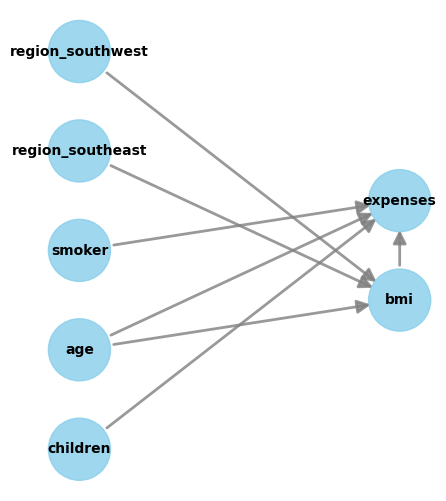

In [4]:
############################################################################################################################################
# Step 1. Modelling (After applying business rules to filter causal hypotheses that violate physical norms)
############################################################################################################################################

causal_graph = nx.DiGraph([
    ('children', 'expenses'),
    ('age', 'expenses'),
    ('smoker', 'expenses'),
    ('bmi', 'expenses'),
    ('age', 'bmi'),
    ('region_southeast', 'bmi'),
    ('region_southwest', 'bmi')
])


plot(causal_graph)




In [5]:
############################################################################################################################################
# Step 2: Identify
############################################################################################################################################

treatment_var = "bmi"
model = dowhy.CausalModel(data=df,
                     graph=causal_graph,
                     treatment=treatment_var,
                     outcome=target_var)

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

#Display methods
#model.view_model()  # Method 1
#from IPython.display import Image, display
#display(Image(filename="causal_model.png")) # Method 2

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
──────(E[expenses|age])
d[bmi]                 
Estimand assumption 1, Unconfoundedness: If U→{bmi} and U→expenses then P(expenses|bmi,age,U) = P(expenses|bmi,age)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                             ↪
 ⎢                 d                             ⎛                 d           ↪
E⎢────────────────────────────────────(expenses)⋅⎜──────────────────────────── ↪
 ⎣d[regionₛₒᵤₜₕₑₐₛₜ  region_southwest]           ⎝d[regionₛₒᵤₜₕₑₐₛₜ  region_so ↪

↪                 -1⎤
↪                ⎞  ⎥
↪ ────────([bmi])⎟  ⎥
↪ uthwest]       ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→expenses then ¬(U →→{region_southeast,region_southwest})
Estimand assumption 2, Exclusion: If we remove {region_southeast,region_southwest}→{bmi}, then ¬({region_southeast,region_southwest}→

In [6]:
treatment_var = "smoker"
model = dowhy.CausalModel(data=df,
                     graph=causal_graph,
                     treatment=treatment_var,
                     outcome=target_var)

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                 
─────────(E[expenses])
d[smoker]             
Estimand assumption 1, Unconfoundedness: If U→{smoker} and U→expenses then P(expenses|smoker,,U) = P(expenses|smoker,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
    d                 
─────────(E[expenses])
d[smoker]             
Estimand assumption 1, Unconfoundedness: If U→{smoker} and U→expenses then P(expenses|smoker,,U) = P(expenses|smoker,)



In [7]:
############################################################################################################################################
# Step 3: Estimate for smoker
############################################################################################################################################

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                 
─────────(E[expenses])
d[smoker]             
Estimand assumption 1, Unconfoundedness: If U→{smoker} and U→expenses then P(expenses|smoker,,U) = P(expenses|smoker,)

## Realized estimand
b: expenses~smoker+smoker*children+smoker*region_southeast+smoker*region_southwest+smoker*bmi+smoker*age
Target units: 

## Estimate
Mean value: 23818.81857277375
### Conditional Estimates
__categorical__children  __categorical__region_southeast  __categorical__region_southwest  __categorical__bmi  __categorical__age
(-0.001, 1.0]            (-0.001, 1.0]                    (-0.001, 1.0]                    (15.999, 25.34]     (17.999, 24.0]        6179.7157
                                                                                                               (24.0, 34.0]          9100.1534
                            

In [8]:
############################################################################################################################################
# Step 4: Refute estimate for smoker
############################################################################################################################################

refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a Placebo Treatment
Estimated effect:23818.81857277375
New effect:225.14799977642434
p value:0.36680744316188496



In [9]:

############################################################################################################################################
# Step 3 and 4: Estimate and refute for bmi (age is a confounder for bmi and expenses)
############################################################################################################################################

'''
DoWhy fits a model of the form for Linear regression: 𝑌 = 𝛼 + 𝜏𝑇 + 𝛽𝐶 + 𝜀
where:

Y = outcome (expenses)
T = treatment (bmi here)
C = backdoor variables (confounders, age here for bmi), if any
τ = causal treatment effect (ATE)
'''


treatment_var = "bmi"
# bmi ← age → expenses

model = dowhy.CausalModel(data=df,
                     graph=causal_graph,
                     treatment=treatment_var,
                     outcome=target_var)

#Step 2: Identify

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


#Step 3: Estimate
dml = True

if not dml:
  estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                target_units="att")
else:
  estimate = model.estimate_effect(
      identified_estimand,
      method_name="backdoor.econml.dml.LinearDML",
      method_params={
        "init_params": {
            "model_y": LassoCV(),
            "model_t": LassoCV(),
            "random_state": 42
        }}
  )

print(estimate)

#Step 4: Refute

refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
──────(E[expenses|age])
d[bmi]                 
Estimand assumption 1, Unconfoundedness: If U→{bmi} and U→expenses then P(expenses|bmi,age,U) = P(expenses|bmi,age)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                             ↪
 ⎢                 d                             ⎛                 d           ↪
E⎢────────────────────────────────────(expenses)⋅⎜──────────────────────────── ↪
 ⎣d[regionₛₒᵤₜₕₑₐₛₜ  region_southwest]           ⎝d[regionₛₒᵤₜₕₑₐₛₜ  region_so ↪

↪                 -1⎤
↪                ⎞  ⎥
↪ ────────([bmi])⎟  ⎥
↪ uthwest]       ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→expenses then ¬(U →→{region_southeast,region_southwest})
Estimand assumption 2, Exclusion: If we remove {region_southeast,region_southwest}→{bmi}, then ¬({region_southeast,region_southwest}→

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was e

Refute: Use a Placebo Treatment
Estimated effect:297.12689211183715
New effect:1.2457540866972487
p value:0.48385855253366805



In [10]:
############################################################################################################################################
# OPTIONAL TO RUN
# Sanity check (Average treatment effect using linear regression)
############################################################################################################################################

import statsmodels.api as sm

# Features and target
X = df[['age', 'bmi', 'smoker', 'children']]
y = df['expenses']

# Add intercept
X = sm.add_constant(X)

# Fit OLS
model = sm.OLS(y, X).fit()

# Results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     998.2
Date:                Fri, 26 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:39:44   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1333   BIC:                         2.714e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.211e+04    941.954    -12.851      0.0

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node region_southwest: 100%|██████████| 7/7 [00:00<00:00, 251.22it/s]
Test permutations of given graph: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


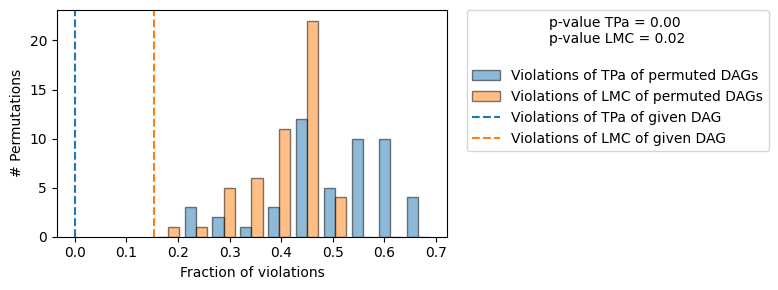

Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the underlying classifier model.
- (normalized) Continuous Ranked P

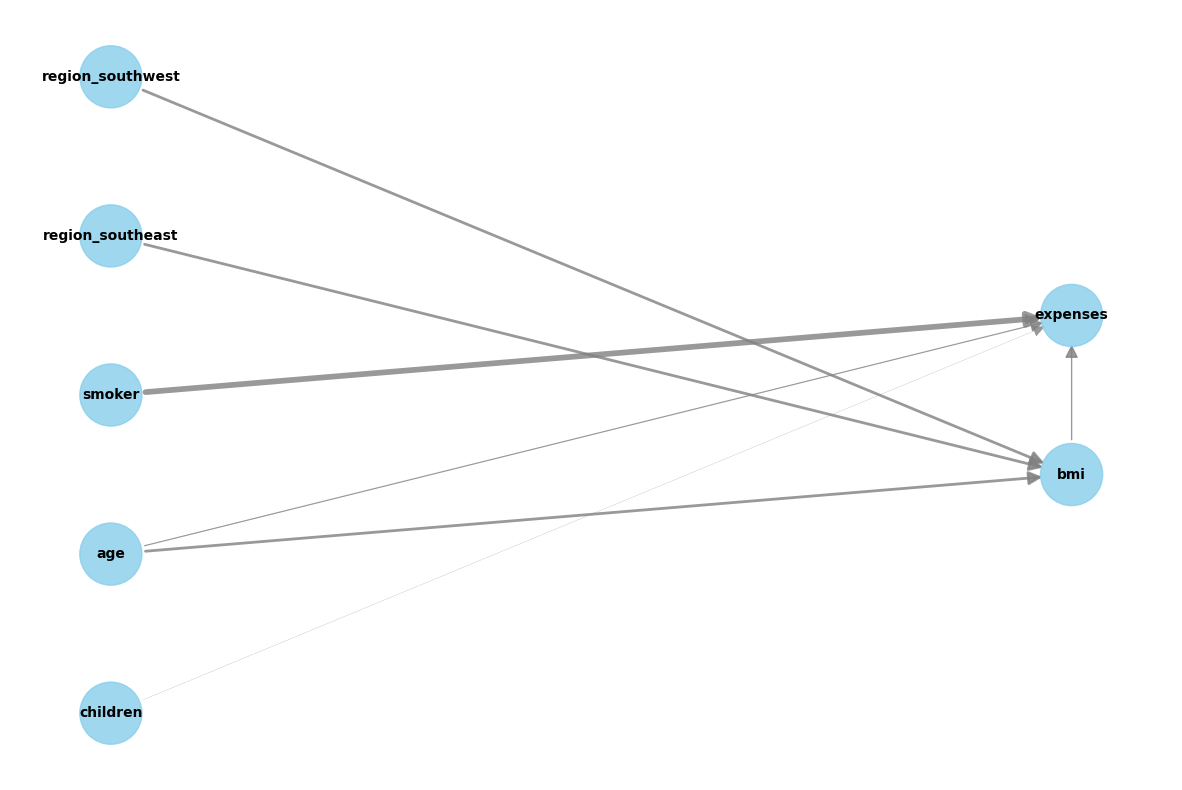

Evaluating set functions...: 100%|██████████| 82/82 [04:51<00:00,  3.56s/it]


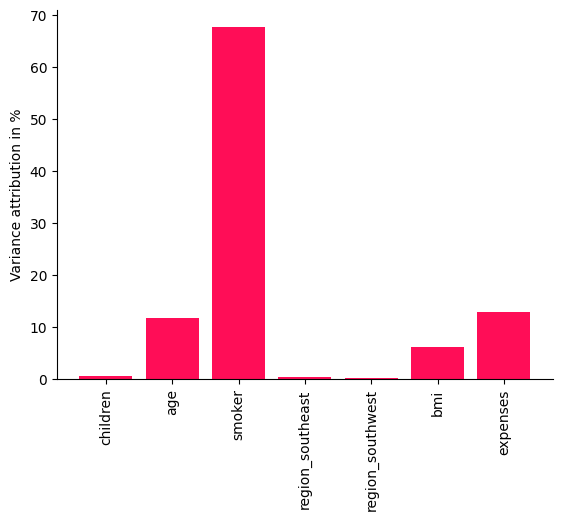

In [11]:
############################################################################################################################################
# OPTIONAL TO RUN
# Structural causal model tests for DoWhy to estimate effects using the entire causal model. Plot for checking the Intrinsic Causal Inference
# ICI: % contribution of each feature in defining the variance of the target feature
############################################################################################################################################

import numpy as np
from dowhy import gcm
from dowhy.utils import bar_plot

# 1. Create the structural causal model
scm = gcm.StructuralCausalModel(causal_graph)

# 2. Assign causal mechanisms (structure is now frozen)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(
    scm,
    df,
    override_models=True,
    quality=gcm.auto.AssignmentQuality.GOOD
)
print(auto_assignment_summary)

# 3. Fit ALL causal mechanisms (this is mandatory)
gcm.fit(scm, df)

# 4. Evaluate causal model quality
print(
    gcm.evaluate_causal_model(
        scm,
        df,
        compare_mechanism_baselines=True,
        evaluate_invertibility_assumptions=False
    )
)

# Utility: percentage conversion
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {
        k: abs(v) / total_absolute_sum * 100
        for k, v in value_dictionary.items()
    }

# 5. Arrow strength (now safe)
arrow_strengths = gcm.arrow_strength(
    scm,
    target_node=target_var
)

plot(
    causal_graph,
    causal_strengths=convert_to_percentage(arrow_strengths),
    figure_size=[15, 10]
)

# 6. Intrinsic causal influence
"""
For the target node: expenses =𝑓(parents,𝑈(expenses))

So there are two sources of variation in expenses:

1. Variation coming through parents (age, smoker, bmi, etc.)

2. Variation coming from its own noise term 𝑈(expenses)

Intrinsic Causal Influence (ICI) explicitly attributes variance to both.
"""

iccs = gcm.intrinsic_causal_influence(
    scm,
    target_node=target_var,
    num_samples_randomization=500
)

bar_plot(
    convert_to_percentage(iccs),
    ylabel="Variance attribution in %"
)


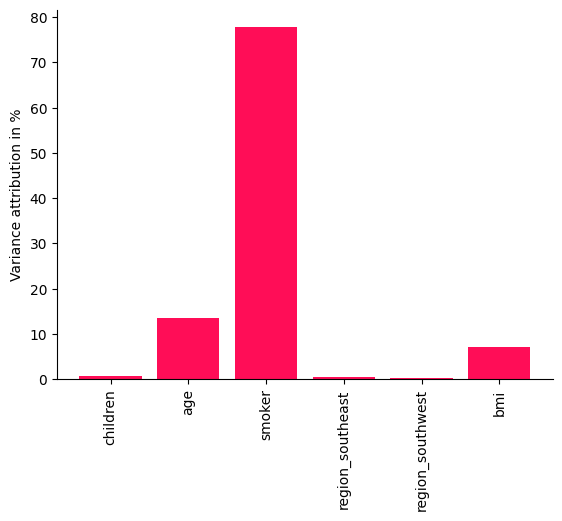

In [12]:
iccs_no_target = {
    k: v for k, v in iccs.items()
    if k != target_var
}

bar_plot(
    convert_to_percentage(iccs_no_target),
    ylabel="Variance attribution in %"
)